In [1]:
# install kaggle package
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# copy kaggle account file 
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:19<00:00, 186MB/s]
100% 2.70G/2.70G [00:19<00:00, 148MB/s]


In [4]:
# unzip dataset
!mkdir Dataset
!unzip /content/new-plant-diseases-dataset.zip -d /content/Dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2

In [5]:
import os
import shutil
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [6]:
!rm -r '/content/Dataset/new plant diseases dataset(augmented)'

In [42]:
IMG_SIZE = [98,98]
n_classes = 38
BATCH_SIZE = 48

In [8]:
import seaborn as sns
import pandas as pd

In [9]:
sns.set(rc={'figure.figsize':(11,5)})

### Transfer-Learning Model

In [10]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 26.2 MB/s 


In [11]:
# import keras modules
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [12]:
# train set and validation set paths
train_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [43]:
# initialize keras datagen and also scale down pixels
# augmentation is included
# splitting train set in to 80:20 where 20% is test set
#
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  zoom_range=0.3,
                                   shear_range=0.2,
                                   validation_split=0.2)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_data = datagen_train.flow_from_directory(train_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          seed=1,
                                          subset='training')

test_data = datagen_train.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                        seed=1,
                                        subset='validation')

valid_data = datagen_valid.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE)

Found 56251 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [44]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = BATCH_SIZE
num_epochs = 4
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (IMG_SIZE[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 2401


In [45]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_data.next()[0])

In [46]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [47]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [48]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [49]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [50]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=IMG_SIZE + [3])
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [51]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    train_data,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=valid_data,
)

Epoch 1/4
1172/1172 [==============================] - 1048s 848ms/step - loss: 1.8441 - accuracy: 0.6210 - top-5-accuracy: 0.8760 - val_loss: 1.2930 - val_accuracy: 0.8224 - val_top-5-accuracy: 0.9840
Epoch 2/4
1172/1172 [==============================] - 991s 846ms/step - loss: 1.1517 - accuracy: 0.8713 - top-5-accuracy: 0.9889 - val_loss: 1.1113 - val_accuracy: 0.8939 - val_top-5-accuracy: 0.9926
Epoch 3/4
1172/1172 [==============================] - 990s 845ms/step - loss: 1.0172 - accuracy: 0.9132 - top-5-accuracy: 0.9948 - val_loss: 1.0372 - val_accuracy: 0.9144 - val_top-5-accuracy: 0.9954
Epoch 4/4
1172/1172 [==============================] - 991s 845ms/step - loss: 0.9606 - accuracy: 0.9291 - top-5-accuracy: 0.9968 - val_loss: 1.0716 - val_accuracy: 0.8972 - val_top-5-accuracy: 0.9937


In [73]:
model.save_weights('transformer.h5')

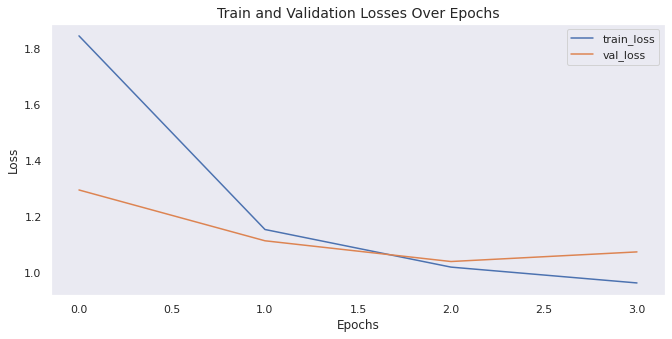

In [54]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [56]:
loss, accuracy, top_5_accuracy = model.evaluate(test_data)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

73/73 [==============================] - 22s 291ms/step - loss: 1.0177 - accuracy: 0.9209 - top-5-accuracy: 0.9971
Test loss: 1.02
Test accuracy: 92.09%
Test top 5 accuracy: 99.71%


In [57]:
loss, accuracy, top_5_accuracy = model.evaluate(valid_data)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

367/367 [==============================] - 102s 278ms/step - loss: 1.0716 - accuracy: 0.8972 - top-5-accuracy: 0.9937
Test loss: 1.07
Test accuracy: 89.72%
Test top 5 accuracy: 99.37%


In [59]:
predict = model.predict(test_data)

In [63]:
pr = np.argmax(predict, axis=1)

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report

In [66]:
# this function will evaluate trained model on validation set
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction,target_names=label_names))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.2f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.2f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.2f}'.format(f1_score(y_true, prediction, average='weighted') * 100))
    cm = confusion_matrix(y_true,prediction)
    print('\n-----------Confusion Matrix------------\n')
    print(cm)
    
    plt.figure(figsize=(17,15))
    plt.imshow(cm , cmap= plt.cm.Blues_r)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks,label_names, rotation = 90)
    plt.yticks(tick_marks,label_names)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'.2f'), ha='center', va='center',
                     color='black' if cm[i,j] > thresh else 'white')
    plt.show()

In [67]:
# we need label encoder of labels so getting it from saved file
import joblib
label_le = joblib.load('labels.pkl')

In [64]:
# extracting images and labels from keras datagen of test set
test_img = []
test_label = []
batch_index = 0

while batch_index <= test_data.batch_index:
    data = test_data.next()
    test_img.extend(data[0])
    test_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
test_img = np.asarray(test_img)

        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.91      0.94       100
                                 Apple___Black_rot       0.99      0.97      0.98        99
                          Apple___Cedar_apple_rust       0.93      0.93      0.93        88
                                   Apple___healthy       0.97      0.84      0.90       100
                               Blueberry___healthy       0.91      0.93      0.92        90
          Cherry_(including_sour)___Powdery_mildew       0.99      0.96      0.98        84
                 Cherry_(including_sour)___healthy       1.00      0.90      0.95        91
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.95      0.93        82
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        95
               

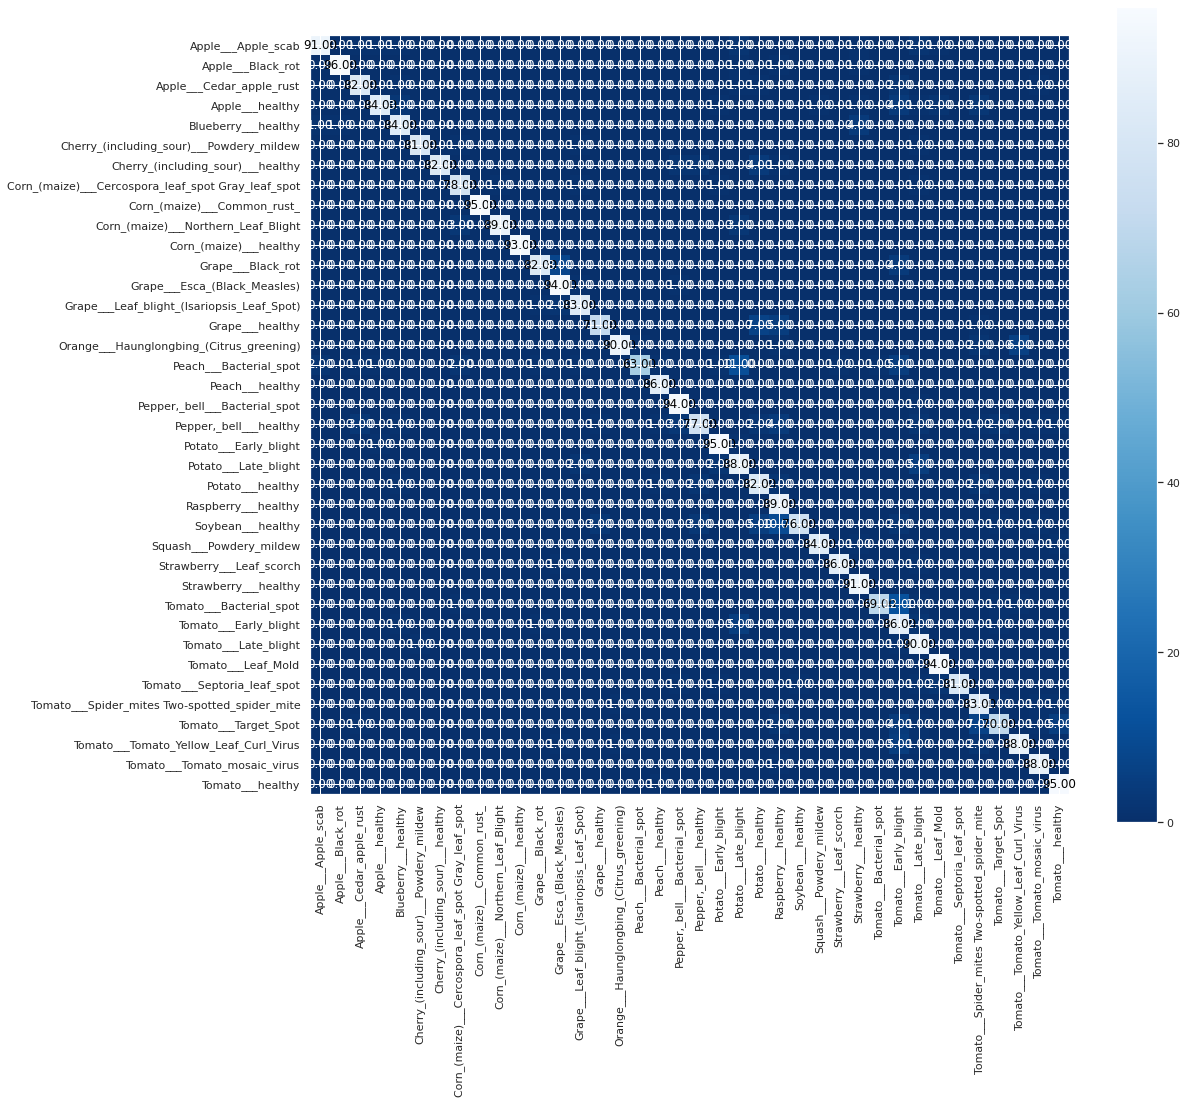

In [68]:
# predicting results of test set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = model.predict(test_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, test_label)

### Validation Evaluation

In [69]:
# extracting images and labels from keras datagen of valid set
valid_img = []
valid_label = []
batch_index = 0

while batch_index <= valid_data.batch_index:
    data = valid_data.next()
    valid_img.extend(data[0])
    valid_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
valid_img = np.asarray(valid_img)

        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.86      0.92       504
                                 Apple___Black_rot       0.93      0.98      0.95       497
                          Apple___Cedar_apple_rust       0.96      0.95      0.95       440
                                   Apple___healthy       0.98      0.76      0.85       502
                               Blueberry___healthy       0.96      0.88      0.92       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.97       421
                 Cherry_(including_sour)___healthy       0.99      0.82      0.90       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.95      0.88       410
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       477
               

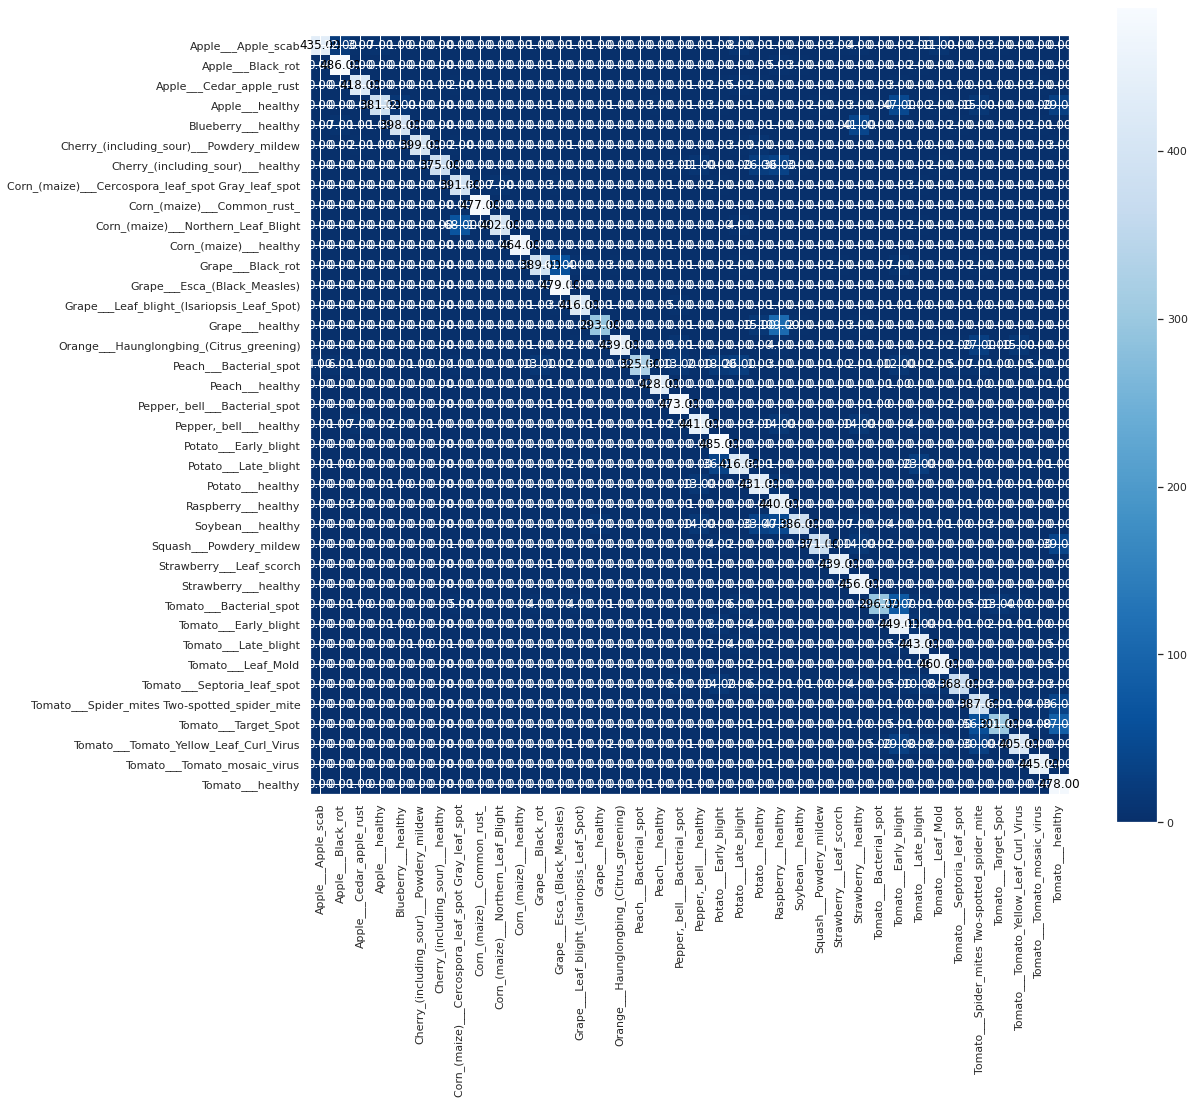

In [70]:
# predicting results of valid set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = model.predict(valid_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, valid_label)